# Load and Preprocess

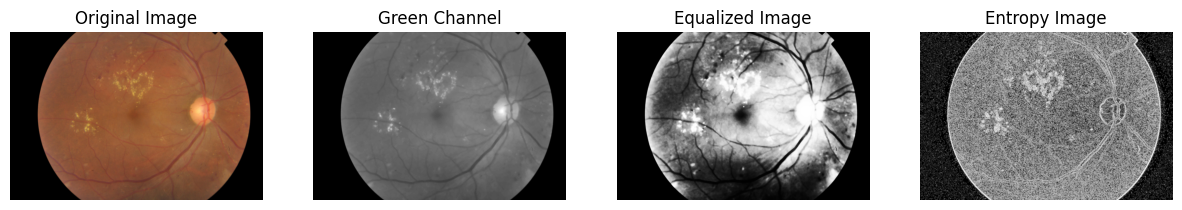

In [41]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from skimage.morphology import skeletonize, label
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the fundus image
    image = cv2.imread(image_path)
    
    # Convert to grayscale to detect the fundus boundary
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## REPLACE BLACK BACKGROUND CODE
    # Threshold the grayscale image to create a binary mask
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    # Find the contours of the fundus region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the largest contour (assumed to be the fundus) on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    # Apply the mask to remove the background in the original image
    image_with_black_bg = cv2.bitwise_and(image, image, mask=mask)

    # Apply denoising to reduce noise in the image
    denoised_image = cv2.fastNlMeansDenoisingColored(image_with_black_bg, None, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # Extract the green channel from the denoised image
    green_channel = denoised_image[:, :, 1]
    
    # Apply a Gaussian filter to smooth the green channel
    smoothed = cv2.GaussianBlur(green_channel, (5, 5), 0)
    
    # Apply histogram equalization to enhance contrast in the green channel
    equalized = cv2.equalizeHist(smoothed)

    entropy_img = entropy(gray, disk(1))
    
    return image_with_black_bg, green_channel, equalized, entropy_img

# Load image
image_path = r"..\..\Data\APTOS-2019 Dataset\train_images\train_images\e229aca862c7.png"

image_with_black_bg, green_channel, equalized_image, entropy_img = load_and_preprocess_image(image_path)

# Visualize the original, green channel, and equalized image
plt.figure(figsize=(15,5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image_with_black_bg, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(green_channel, cmap='gray')
plt.title("Green Channel")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(entropy_img, cmap='gray')
plt.title("Entropy Image")
plt.axis('off')

plt.show()

#  Blood Vessel Detection and Counting

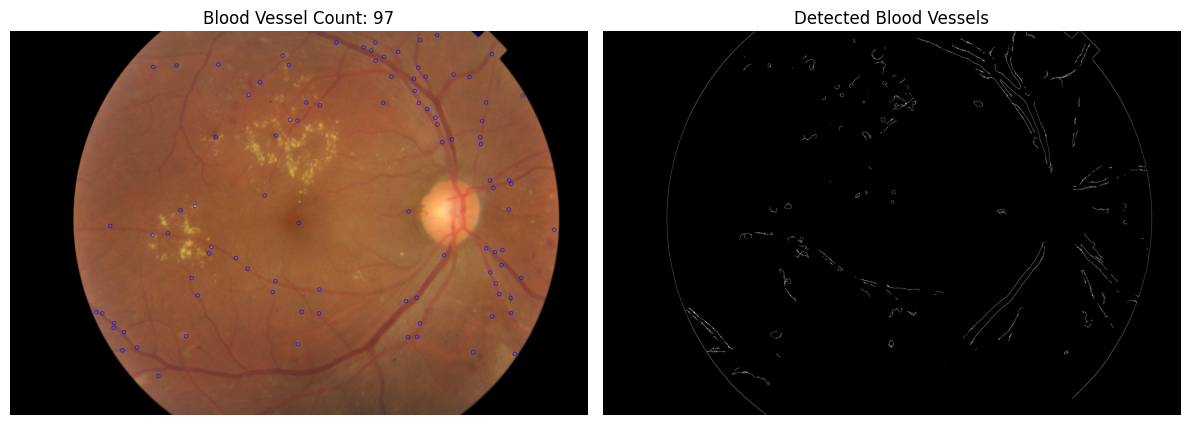

In [42]:
# NEED TO MAKE IGNORE YELLOW SPOTS ND BE MORE SENSITIVE TO SMALLER BLOOD VESSELS

# Blood vessel detection using Canny edge detection and morphological operations
def detect_blood_vessels(equalized_image):
    # Use Canny Edge Detection for blood vessels
    edges = cv2.Canny(equalized_image, threshold1=50, threshold2=150)
    
    # Morphological operations to enhance vessels
    kernel = np.ones((2, 2), np.uint8)
    vessels = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
    return vessels

# Detect blood vessels
vessels = detect_blood_vessels(equalized_image)

# Detect and count blood vessel segments
def count_blood_vessels(vessels):
    # Find connected components of the blood vessels
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(vessels, connectivity=8)
    
    # Filter out small components (noise)
    filtered_labels = [centroid for i, centroid in enumerate(centroids) if stats[i][4] > 80]  # area threshold of 50
    
    return len(filtered_labels), filtered_labels

# Count blood vessels
vessel_count, vessel_centroids = count_blood_vessels(vessels)

# Visualize vessel centroids on the original image
marked_image = image_with_black_bg.copy()
for centroid in vessel_centroids:
    x, y = int(centroid[0]), int(centroid[1])
    cv2.circle(marked_image, (x, y), 10, (255, 0, 0), 2)  # Blue circle for vessels

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the marked image with the vessel count
axs[0].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
axs[0].set_title(f"Blood Vessel Count: {vessel_count}")
axs[0].axis('off')

# Plot the detected blood vessels
axs[1].imshow(vessels, cmap='gray')
axs[1].set_title("Detected Blood Vessels")
axs[1].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


# Exudate Detection

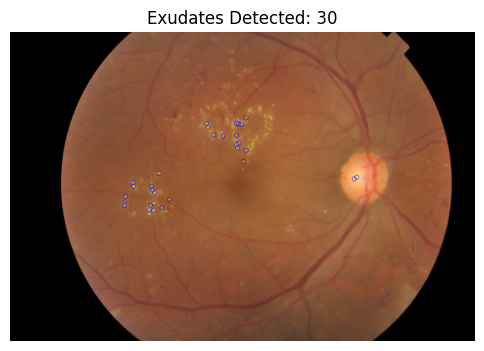

Number of detected exudates: 30


In [43]:
# NEED IT TO PICK UP MORE OF THE YELLOW SPOTS

# Function to detect exudates based on color in the HSV space
def detect_exudates_by_color(original_image):
    # Convert image to HSV
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper bounds for yellow in HSV (exudates are often yellowish)
    lower_yellow = np.array([20, 50, 50])  # Adjust these values as needed
    upper_yellow = np.array([40, 255, 255])
    
    # Create a binary mask where yellow regions are detected
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    
    # Apply morphological operations to remove noise and small false detections
    kernel = np.ones((5, 5), np.uint8)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel)
    
    # Label connected regions (exudates)
    labels = measure.label(yellow_mask, connectivity=2)
    regions = measure.regionprops(labels)
    
    return yellow_mask, labels, regions

# Function to mark detected exudates on the original image
def mark_exudates_on_image(image, exudate_regions):
    marked_image = image.copy()

    # Draw circles around detected exudates
    for region in exudate_regions:
        # Get the centroid of each exudate region
        y, x = region.centroid
        
        # Draw a circle around the centroid on the original image
        cv2.circle(marked_image, (int(x), int(y)), 15, (255, 0, 0), 2)  # Blue circles

    return marked_image


# Detect exudates based on yellow color in the original image
yellow_mask, labels, exudate_regions = detect_exudates_by_color(image_with_black_bg)

# Mark exudates on the original image
marked_image = mark_exudates_on_image(image_with_black_bg, exudate_regions)

# Display the marked image with exudates
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Exudates Detected: {len(exudate_regions)}")
plt.axis('off')
plt.show()

# Print the count of detected exudates
print(f"Number of detected exudates: {len(exudate_regions)}")

# Bifurcation Detection

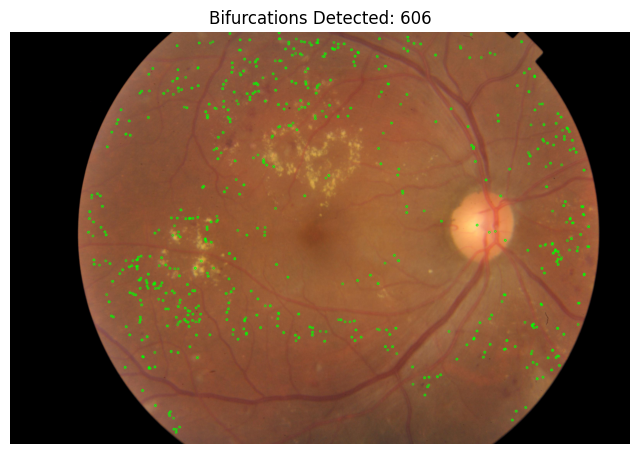

Number of detected bifurcations: 606


In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label
# Ensure necessary modules are imported
from skimage.filters import threshold_otsu

# Function to detect bifurcations in the skeletonized vessel image
def detect_bifurcations(vessel_image):
    # Skeletonize the vessel image (reduce vessels to 1-pixel width)
    skeleton = skeletonize(vessel_image // 255)
    
    # Initialize neighbors array
    neighbors = np.zeros(skeleton.shape, dtype=int)

    # Count neighbors by rolling the skeletonized image
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx != 0 or dy != 0:
                neighbors += np.roll(np.roll(skeleton, dx, axis=0), dy, axis=1)

    # Identify bifurcation points (where the number of neighbors is greater than 2)
    bifurcations = ((neighbors > 2) & skeleton).astype(np.uint8)

    # Label bifurcations and count them
    bifurcation_labels = label(bifurcations)
    bifurcation_count = len(np.unique(bifurcation_labels)) - 1  # Subtract 1 for background

    return bifurcations, bifurcation_count

# Function to mark detected bifurcations on the original image
def mark_bifurcations_on_image(image, bifurcation_points):
    if image is None:
        raise ValueError("The input image is None. Please ensure the image is correctly loaded and processed.")
    
    marked_image = image.copy()

    # Find coordinates of bifurcation points
    bifurcation_coords = np.column_stack(np.nonzero(bifurcation_points))

    # Draw circles on the original image at bifurcation points
    for y, x in bifurcation_coords:
        cv2.circle(marked_image, (x, y), 5, (0, 255, 0), 2)  # Green circles for bifurcations

    return marked_image

# Ensure the image is correctly loaded and processed
if image_with_black_bg is None:
    print("Error: The image was not loaded correctly. Please check the image path and loading function.")
else:
    # Preprocess the image to create a binary vessel map using Otsu's thresholding
    threshold_value = threshold_otsu(equalized_image)
    vessels = (equalized_image > threshold_value).astype(np.uint8) * 255

    # Detect bifurcations in the skeletonized vessel image
    bifurcations, bifurcation_count = detect_bifurcations(vessels)

    # Mark bifurcations on the original image
    marked_image = mark_bifurcations_on_image(image_with_black_bg, bifurcations)

    # Display the marked image with bifurcations
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Bifurcations Detected: {bifurcation_count}")
    plt.axis('off')
    plt.show()

    # Print the count of detected bifurcations
    print(f"Number of detected bifurcations: {bifurcation_count}")

# Large Oedema Detection

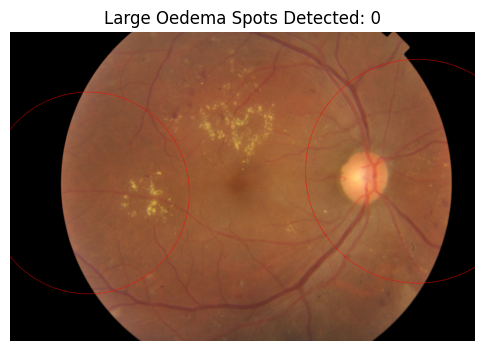

Number of detected large oedema spots: 0


In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to detect large oedema spots using adaptive thresholding and HSV filtering
def detect_large_oedema_spots(original_image, min_area=5000, threshold_factor=1.5):
    # Step 1: Convert the image to HSV space
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Step 2: Extract the V channel (brightness) for thresholding
    v_channel = hsv_image[:, :, 2]

    # Step 3: Apply Gaussian blur to the V channel to reduce noise
    blurred_image = cv2.GaussianBlur(v_channel, (5, 5), 0)

    # Step 4: Apply adaptive thresholding to better detect bright oedema spots
    binary_objects = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Step 5: Morphological operations to clean up small regions and noise
    kernel = np.ones((5, 5), np.uint8)
    binary_objects = cv2.morphologyEx(binary_objects, cv2.MORPH_OPEN, kernel)
    binary_objects = cv2.morphologyEx(binary_objects, cv2.MORPH_CLOSE, kernel)

    # Step 6: Find contours (outlines) of the objects
    contours, _ = cv2.findContours(binary_objects, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 7: Create an empty image for large objects
    large_objects = np.zeros_like(binary_objects, dtype=np.uint8)
    large_object_count = 0
    
    # Step 8: Filter and count objects based on area and circularity
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            # Circularity filter to detect round oedema spots
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter ** 2)
                if 0.7 < circularity < 1.2:  # Adjust circularity range for round shapes
                    cv2.drawContours(large_objects, [contour], -1, 1, thickness=cv2.FILLED)  # Fill in the large object
                    large_object_count += 1
    
    return large_objects, large_object_count, contours

# Function to mark detected large oedema spots on the original image
def mark_large_oedema_on_image(image, contours, min_area=1000):
    marked_image = image.copy()
    
    # Draw circles around the large oedema spots
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:  # Filtering based on the minimum area
            # Get the center and radius of the minimum enclosing circle
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            # Draw the circle on the original image
            cv2.circle(marked_image, center, radius, (0, 0, 255), 2)  # Red circles for oedema spots
    
    return marked_image

# Example usage:
# Detect large oedema spots in the original image
large_oedema_spots, oedema_count, contours = detect_large_oedema_spots(image_with_black_bg)

# Mark oedema spots on the original image
marked_image = mark_large_oedema_on_image(image_with_black_bg, contours)

# Display the marked image with large oedema spots
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Large Oedema Spots Detected: {oedema_count}")
plt.axis('off')
plt.show()

# Print the count of detected large oedema spots
print(f"Number of detected large oedema spots: {oedema_count}")


# Red Spots (Small Heamatomas) Detection

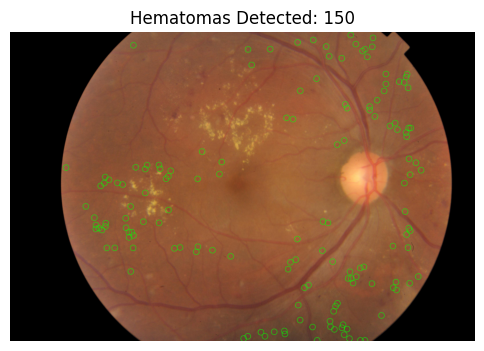

Number of detected hematomas: 150


In [46]:
import cv2
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt

# Function to detect hematomas based on a darker, hazy red color in the HSV space
def detect_hematomas_by_color(original_image, min_area=100, max_area=800, min_intensity=80):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Define narrower HSV bounds for darker, hazy red (hematomas)
    lower_red1 = np.array([0, 70, 30])   # Lower brightness and saturation for dark reds
    upper_red1 = np.array([10, 255, 180])  
    lower_red2 = np.array([170, 70, 30])
    upper_red2 = np.array([180, 255, 180])

    # Create binary masks for dark red regions
    red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    # Apply morphological operations to remove small noise
    kernel = np.ones((5, 5), np.uint8)  
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

    # Label connected regions (hematomas)
    labels = measure.label(red_mask, connectivity=2)
    regions = measure.regionprops(labels)

    # Filter regions based on size, circularity, and color intensity
    hematoma_regions = []
    for region in regions:
        if min_area < region.area < max_area:  # Adjust the area range based on larger hematoma sizes
            circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)
            if 0.6 < circularity < 1.3:  # Relax the circularity range for less perfect shapes
                # Create a mask for the current region
                region_mask = np.zeros_like(red_mask)
                region_mask[region.coords[:, 0], region.coords[:, 1]] = 1
                
                # Check color intensity within the region
                mean_intensity = np.mean(hsv_image[:, :, 2][region_mask == 1])  # V channel from HSV
                if mean_intensity > min_intensity:  # Lower intensity threshold for darker reds
                    hematoma_regions.append(region)

    return red_mask, hematoma_regions

# Function to mark detected hematomas on the original image
def mark_hematomas_on_image(image, hematoma_regions):
    marked_image = image.copy()

    # Draw circles around detected hematomas
    for region in hematoma_regions:
        y, x = region.centroid
        cv2.circle(marked_image, (int(x), int(y)), 20, (0, 255, 0), 2)  # Larger green circles

    return marked_image


# Example usage:
# Detect hematomas in the image
red_mask, hematoma_regions = detect_hematomas_by_color(image_with_black_bg)

# Mark hematomas on the original image
marked_image = mark_hematomas_on_image(image_with_black_bg, hematoma_regions)

# Count the number of detected hematomas
hematoma_count = len(hematoma_regions)

# Display the marked image with hematomas
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.title(f"Hematomas Detected: {hematoma_count}")
plt.axis('off')
plt.show()

# Print the count of detected hematomas
print(f"Number of detected hematomas: {hematoma_count}")


# Image Clarity

In [52]:
import cv2
import numpy as np

# Function to calculate normalized image clarity score (0 to 1)
def calculate_image_clarity_normalized(image, min_variance=0.1, max_variance=50.0):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the Laplacian of the image and calculate the variance
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    variance = laplacian.var()
    
    # Normalize the clarity score between 0 and 1
    normalized_clarity = (variance - min_variance) / (max_variance - min_variance)
    
    # Clip the value to make sure it's between 0 and 1
    normalized_clarity = np.clip(normalized_clarity, 0, 1)
    
    return variance, normalized_clarity

# Example usage with your image
image_clarity_value, clarity_grade_normalized = calculate_image_clarity_normalized(image_with_black_bg)

# Print the clarity result
print(f"Image Clarity Value (Variance): {image_clarity_value:.2f}")
print(f"Image Clarity Score (Normalized): {clarity_grade_normalized:.2f}")


Image Clarity Value (Variance): 5.61
Image Clarity Score (Normalized): 0.11


# Saving Features to Excel/CVS

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import os
import pandas as pd

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the fundus image
    image = cv2.imread(image_path)
    
    # Convert to grayscale to detect the fundus boundary
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## REPLACE BLACK BACKGROUND CODE
    # Threshold the grayscale image to create a binary mask
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    # Find the contours of the fundus region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the largest contour (assumed to be the fundus) on the mask
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    # Apply the mask to remove the background in the original image
    image_with_black_bg = cv2.bitwise_and(image, image, mask=mask)

    # Apply denoising to reduce noise in the image
    denoised_image = cv2.fastNlMeansDenoisingColored(image_with_black_bg, None, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # Extract the green channel from the denoised image
    green_channel = denoised_image[:, :, 1]
    
    # Apply a Gaussian filter to smooth the green channel
    smoothed = cv2.GaussianBlur(green_channel, (5, 5), 0)
    
    # Apply histogram equalization to enhance contrast in the green channel
    equalized = cv2.equalizeHist(smoothed)
    
    return image_with_black_bg, green_channel, equalized

# Initialize an empty DataFrame to store the feature extraction data
output_data = pd.DataFrame(columns=['Image Name', 'Exudates', 'Oedema', 'Vessel Count', 'Heamotomas', 'Bifurcations', 'Clarity', 'Diabetes Status'])

# Load the CSV file with diabetes status
diabetes_status_file = r"..\..\Data\APTOS-2019 Dataset\test.csv"
diabetes_status_df = pd.read_csv(diabetes_status_file)

# Convert the status into 1 (diabetes) and 0 (no diabetes)
diabetes_status_df['Diabetes Status'] = diabetes_status_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

# Function to process the image and extract features
def process_image(image_path):

    # Extract the image name from the full path
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    image_with_black_bg, green_channel, equalized_image = load_and_preprocess_image(image_path)

    # Blood Vessels Count
    vessels = detect_blood_vessels(equalized_image)
    vessel_count, vessel_centroids = count_blood_vessels(vessels)

    # Bifurcations count
    #vessels = (equalized_image > filters.threshold_otsu(equalized_image)).astype(np.uint8) * 255
    #bifurcations, bifurcation_count = detect_bifurcations(vessels)
    # Preprocess the image to create a binary vessel map using Otsu's thresholding
    threshold_value = threshold_otsu(equalized_image)
    vessels = (equalized_image > threshold_value).astype(np.uint8) * 255

    # Detect bifurcations in the skeletonized vessel image
    bifurcations, bifurcation_count = detect_bifurcations(vessels)

    # Exudate Count
    yellow_mask, labels, exudate_count = detect_exudates_by_color(image_with_black_bg)

    # Oedema Count
    large_oedema_spots, oedema_count, contours = detect_large_oedema_spots(image_with_black_bg)

    # Haemotoma Count
    red_mask, heamotoma_count = detect_hematomas_by_color(image_with_black_bg)

    # Retrieve diabetes status for the image from the CSV file
    diabetes_status = diabetes_status_df.loc[diabetes_status_df['id_code'] == image_name, 'Diabetes Status'].values[0]

    # Image Clarity
    image_clarity_value, clarity_grade_normalized = calculate_image_clarity_normalized(image_with_black_bg)

    # Append the extracted data to the DataFrame
    output_data.loc[len(output_data)] = [image_name, len(exudate_count), oedema_count, vessel_count, len(heamotoma_count), bifurcation_count, clarity_grade_normalized, diabetes_status]

# Function to save the results to a CSV file
def save_to_csv(output_file):
    output_data.to_csv(output_file, index=False)

# Main processing loop for all images in a folder, but limited to the first 10 images
def process_images_in_folder(image_folder):
    processed_count = 0  # Counter to track number of processed images

    # Process all images in the folder
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        
        # Ensure it's an image file and process if within limit
        if image_file.endswith(('.png', '.jpg', '.jpeg')):
            process_image(image_path)
            processed_count += 1

            if processed_count % 10 == 0:
                print("10 images done")
            
            # Stop after processing 10 images
            #if processed_count >= 3:
                #break

# Main execution block
if __name__ == "__main__":
    image_folder = r"..\..\Data\APTOS-2019 Dataset\resized_test_images"
    
    # Process only the first 10 images in the folder
    process_images_in_folder(image_folder)

    # Save the results to a CSV file
    save_to_csv('feature_extraction_700_test.csv')  # Uncomment this line for CSV output



10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done
10 images done


In [64]:
import pandas as pd

# Load both CSV files
feature_df = pd.read_csv('feature_extraction_new.csv')
train_df = pd.read_csv(r"..\..\Data\APTOS-2019 Dataset\train_with_val.csv")

# Create a dictionary from train_with_val.csv where id_code is the key and diagnosis is the value
diagnosis_dict = dict(zip(train_df['id_code'], train_df['diagnosis']))

# Function to update Diabetes Status based on train_with_val.csv diagnosis
def update_diabetes_status(image_name):
    # Check if the image name exists in the diagnosis dictionary
    if image_name in diagnosis_dict:
        diagnosis = diagnosis_dict[image_name]
        # If diagnosis is 0, mark as 0 (non-diabetic), otherwise mark as 1 (diabetic)
        return 0 if diagnosis == 0 else 1
    return 1  # Default to 1 if no match is found in the diagnosis CSV

# Apply the function to update the Diabetes Status column
feature_df['Diabetes Status'] = feature_df['Image Name'].apply(update_diabetes_status)

# Save the updated DataFrame to a new CSV file
feature_df.to_csv('feature_extraction_updated.csv', index=False)

print("Diabetes Status updated and saved to 'feature_extraction_updated.csv'.")


Diabetes Status updated and saved to 'feature_extraction_updated.csv'.
